In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
import numpy as np
import torch
import torch.nn.functional as F
torch.autograd.set_detect_anomaly(True)

import mediapy as mpy
from tqdm.auto import tqdm
from IPython.display import clear_output

from nca_model import NCAModel
from utils import nca_out_to_vids
from mnist_data import MNISTGenerator
from clf_patterns import RadialCirclesProcessor, generate_start_pattern

In [23]:
device = "cuda"
num_classes = 10
chans = 16
bs = 16
S = 64
lr = 0.001

In [4]:
nca = NCAModel(channel_n=chans, fire_rate=0.1, device=device)

In [5]:
inp = torch.rand(5, chans, S, S).to(device)
out = nca(inp, steps=50)
len(out), out[0].shape

(51, torch.Size([5, 16, 64, 64]))

,,,,

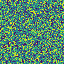
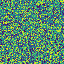
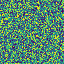
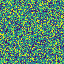
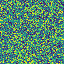

In [6]:
nca_out_to_vids(out)

In [7]:
gen = MNISTGenerator(bs=bs, num_classes=num_classes)

In [8]:
radial_processor = RadialCirclesProcessor(num_classes=num_classes, S=S)
start_pattern = generate_start_pattern(num_classes=num_classes, S=S)

""

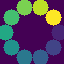

In [9]:
mpy.show_image(radial_processor.screen, cmap="viridis", width=200)

""

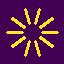

In [10]:
mpy.show_image(start_pattern, cmap="viridis", width=200)

In [54]:
batch = next(gen)
inp, out = radial_processor.map_batch(batch, chans=chans)

,,,,,,,
,,,,,,,

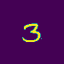
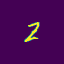
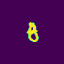
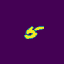
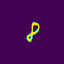
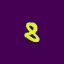
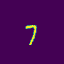
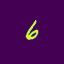
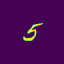
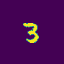
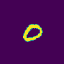
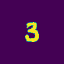
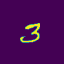
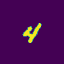
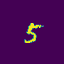
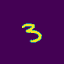

In [13]:
mpy.show_images(inp[:,0], cmap="viridis", width=100, columns=8)

,,,,,,,
,,,,,,,

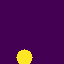
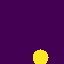
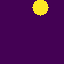
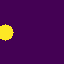
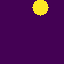
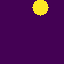
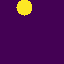
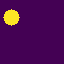
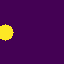
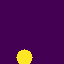
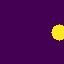
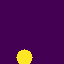
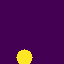
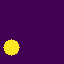
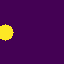
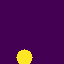

In [14]:
mpy.show_images(out, cmap="viridis", width=100, columns=8)

In [56]:
nca = NCAModel(channel_n=chans, fire_rate=0.1, device=device)
gen = MNISTGenerator(bs=bs, num_classes=num_classes)

radial_processor = RadialCirclesProcessor(num_classes=num_classes, S=S)
start_pattern = generate_start_pattern(num_classes=num_classes, S=S)

optim = torch.optim.Adam(nca.parameters(), lr=lr)

In [58]:
pbar = tqdm(range(50_000))

for i in pbar:
    batch = next(gen)
    inp, out_gt = radial_processor.map_batch(batch, chans=chans)
    out_pred = nca(inp.to(device), steps=np.random.randint(50, 55))

    last_frame = out_pred[-1][:, 0]
    loss = F.mse_loss(out_gt.to(device), last_frame)

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.set_description(f"Loss: {loss:.10f}")

  0%|          | 0/50000 [00:00<?, ?it/s]


KeyboardInterrupt

